In [1]:
#calling all required imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START , END
from langgraph.graph.message import add_messages
import os
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langchain.tools import tool
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from sympy import sympify
import requests
from langchain_tavily import TavilySearch

# <u> LEVEL 1 </u> :-

In [2]:
#defining our state
class State (TypedDict):
    messages : Annotated[list,add_messages]

In [3]:
#linking the gemini model using our api key
gemini_api_key = "" #put your gemini api key here as a string

os.environ["GOOGLE_API_KEY"] = gemini_api_key
llm = init_chat_model("google_genai:gemini-2.0-flash")

#Function to call our llm model
def call_llm_model(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# <u> LEVEL 2 </u> :-

In [4]:

#Creating tools:

# CALC TOOL USES SYMPY LIBRARY WHICH PROCESSES INPUTS AND APLLIES BODMAS RULE
@tool
def calc(expr : str): 
    '''Calculator using sympy'''
    try:
        result = sympify(expr).evalf()
        return result
    except Exception as e:
        return e

# WEATHERMAPTOOL USES OPENWEATHERMAP API TO CHECK WEATHER
@tool
def weatherMap(city :str)->dict :
    ''' check weather using openweathermap API'''
    base_url = "https://api.openweathermap.org/data/2.5/weather?"
    
    api_key = "" #put your gemini api key here
    
    actual_URL = base_url + "appid=" + api_key  + "&q=" + city + "&units=metric"
    response = requests.get(actual_URL).json()
    return response

# Tavily is search engine tool which we use for handling fashion trend prompts or toher prompts requiring the agen to browse the web
os.environ["TAVILY_API_KEY"]= "" #SET YOUR TAVILY API KEY HERE 
tavilyTool = TavilySearch(max_results=2)
    

llm = llm.bind_tools([calc,weatherMap,tavilyTool])

### Here I used langgraph.prebuilt.ToolNode to build a tool node instead of manually writing the function
#### The below code was necessary because the build_calc and build_weather are not callable. I found out this way after searching a lot to figure out this issue and how to resolve it

In [5]:
build_calc = ToolNode(tools= [calc])
#print(callable(build_calc))
def calc_node(state):
    return build_calc.invoke(state)

build_weather = ToolNode(tools=[weatherMap])
#print(callable(build_weather))
def weather_node(state):
    return build_weather.invoke(state)

build_tavily = ToolNode(tools=[tavilyTool])
# def tavily_node(state):
#     return build_tavily.invoke(state)
    

In [6]:
#Function to display the graph visually

def printGraph(graph):
    display(Image(graph.get_graph().draw_mermaid_png()))
    
        

# <u> LEVEL 3 </u>:-

### Defining a routing function to route the agent to the required tool :-

In [7]:
#Defining a function which checks whether or not to call the calc tool
#The comments were to handle the issues while debugging
def route(state : State)->State:
    last_message = state["messages"][-1]
    
    #print(last_message)
    #print(len(last_message.tool_calls))
    #print(message)
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        #print("reached")
        tool = last_message.tool_calls[0]["name"]
        #print(tool)
        if tool == "weatherMap" :
            return "weather"
        elif tool == "calc" :
            return "calc"
        elif tool == "tavily_search":
            #print("reached")
            return "tavily"
        return END
    return END 
    


## Defining our workflow/graph nodes and edges (and viewing it pictorially):-

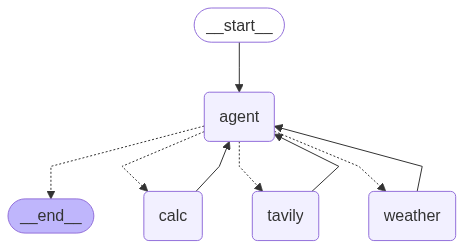

In [8]:
workflow = StateGraph(State)
workflow.add_node("agent" , call_llm_model)
workflow.add_edge(START,"agent")

workflow.add_node("weather" , weather_node)
workflow.add_node("calc",calc_node)
workflow.add_node("tavily",build_tavily)
workflow.add_conditional_edges("agent", route , {"weather" : "weather", "calc" : "calc" , "tavily" : "tavily" , END : END})

workflow.add_edge("weather" , "agent")
workflow.add_edge("calc", "agent")
workflow.add_edge("tavily","agent")
graph = workflow.compile()
printGraph(graph)
                         

## Function to stream inputs from the user and generate an answer:-

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        #print(event)
        for key,value in event.items():
            if key == "agent" and len(value["messages"][-1].content) > 0:
                print("Assistant:", value["messages"][-1].content)

            #This if is necessary because then for one prompt I was getting multiple outputs. Reason was that in our dictionary event we
            #had more than one keys corresponding to the agent, tool and agent again repsectively

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit","see you","goodbye" , "bye bye","bye" , "failed to get input, goodbye"]:
            print("Assistant : Have a great day!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "bye"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  Hello how are you


Assistant: I am doing well, thank you for asking. How can I help you today?


User:  whats your name


Assistant: I am Gemini, a large language model built by Google.


User:  can you tell the current weather in Guwahati


Assistant: The current weather in Guwahati is mist with a temperature of 27.95 degrees Celsius. The humidity is 94% and the wind speed is 0.


User:  What about the current temperature in Mumbai?


Assistant: The current temperature in Mumbai is 29.99 degrees Celsius. It feels like 36.99 degrees Celsius. The weather condition is haze.


User:  What are the current fashion trends in Tokyo?


Assistant: Current fashion trends in Tokyo include wide-leg pants, kitten heels, short sleeve blouses, loose dresses and basket bags. Other popular trends include oversized looks and the E-girl aesthetic.


User:  What are some trending fashion styles in South Korea?


Assistant: Based on the search results, some trending fashion styles in South Korea include:

*   **Y2K tops:** Early 2000s-inspired garments with vibrant colors, unique patterns, and playful details.
*   **Sustainable fashion:** An increasing emphasis on eco-friendly and ethical clothing choices.


User:  goodbye


Assistant : Have a great day!


### Due to lack of time I could not implement conversational memory. Multi-agent systems seem beyond my scope for now. Enjoyed this task as well. Thank you!